In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats, special

 - https://en.wikipedia.org/wiki/Logit-normal_distribution
 - https://en.wikipedia.org/wiki/Logistic_function
 - https://en.wikipedia.org/wiki/Logit
 
 - https://github.com/scipy/scipy/blob/v1.8.1/scipy/stats/_continuous_distns.py#L5365-L5499
 
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html?highlight=rv_continous
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.logit.html
 
 - https://github.com/statsmodels/statsmodels/blob/main/statsmodels/sandbox/distributions/transformed.py#L55
 - https://github.com/scipy/scipy/issues/12133
 
 - https://stackoverflow.com/questions/60669256/how-do-you-create-a-logit-normal-distribution-in-python
 
![Example](https://upload.wikimedia.org/wikipedia/commons/a/ae/LogitnormDensityGrid.svg)
 

In [2]:
class logitnorm_gen(stats.rv_continuous):

    def _argcheck(self, s, m):
        return (s > 0.) & (m >= 0.)
    
    def _pdf(self, x, s, m):
        return stats.norm(loc=m, scale=s).pdf(special.logit(x))/(x*(1-x))
    
    def _cdf(self, x, s, m):
        return stats.norm(loc=m, scale=s).cdf(special.logit(x))
    
    def _rvs(self, s, m, size=None, random_state=None):
        return special.expit(m + s*random_state.standard_normal(size))
    
    def fit(self, data, **kwargs):
        data = special.logit(data)
        return stats.norm.fit(data, **kwargs)

logitnorm = logitnorm_gen(a=0.0, b=1.0, name="logitnorm")

In [3]:
fixtures = []
for (mu, sigma) in itertools.product([0.0, 0.5, 1.0, 1.5, 2.0], [0.32, 0.56, 1.00, 1.78, 3.16]):
    fixtures.append({"parameters": {"loc": mu, "scale": sigma}, "size": 1000, "seed": 486})

KstestResult(statistic=nan, pvalue=nan)
{'parameters': {'loc': 0.0, 'scale': 0.32}, 'size': 1000, 'seed': 486} True
KstestResult(statistic=nan, pvalue=nan)
{'parameters': {'loc': 0.0, 'scale': 0.56}, 'size': 1000, 'seed': 486} True
KstestResult(statistic=nan, pvalue=nan)
{'parameters': {'loc': 0.0, 'scale': 1.0}, 'size': 1000, 'seed': 486} True
KstestResult(statistic=nan, pvalue=nan)
{'parameters': {'loc': 0.0, 'scale': 1.78}, 'size': 1000, 'seed': 486} True
KstestResult(statistic=nan, pvalue=nan)
{'parameters': {'loc': 0.0, 'scale': 3.16}, 'size': 1000, 'seed': 486} True
KstestResult(statistic=0.21060719900341274, pvalue=2.1496525839582902e-39)
{'parameters': {'loc': 0.5, 'scale': 0.32}, 'size': 1000, 'seed': 486} True
KstestResult(statistic=0.11013518822273177, pvalue=5.0935562682881357e-11)
{'parameters': {'loc': 0.5, 'scale': 0.56}, 'size': 1000, 'seed': 486} True
KstestResult(statistic=0.385237346646863, pvalue=4.815797037649941e-134)
{'parameters': {'loc': 0.5, 'scale': 1.0}, 'si

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


KstestResult(statistic=0.5527369655505903, pvalue=1.0835480952633475e-287)
{'parameters': {'loc': 2.0, 'scale': 0.56}, 'size': 1000, 'seed': 486} True
KstestResult(statistic=0.33285813421133814, pvalue=2.936802790745499e-99)
{'parameters': {'loc': 2.0, 'scale': 1.0}, 'size': 1000, 'seed': 486} True
KstestResult(statistic=0.03909301489456324, pvalue=0.09163828705311428)
{'parameters': {'loc': 2.0, 'scale': 1.78}, 'size': 1000, 'seed': 486} True
KstestResult(statistic=0.2749174031858631, pvalue=2.7395443360613163e-67)
{'parameters': {'loc': 2.0, 'scale': 3.16}, 'size': 1000, 'seed': 486} True


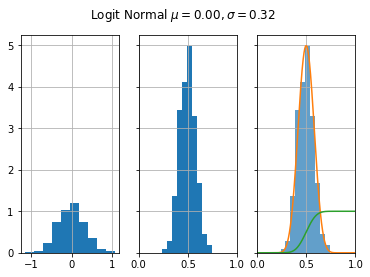

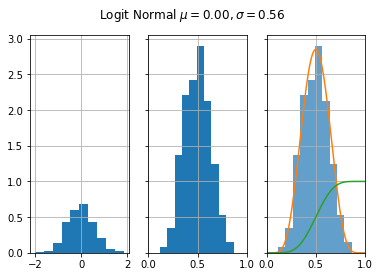

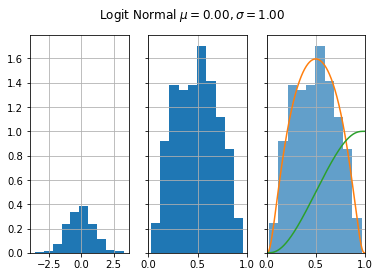

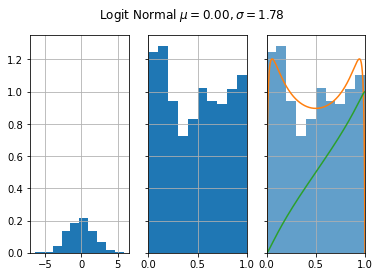

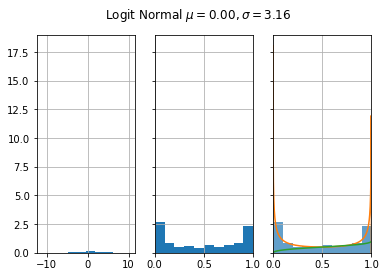

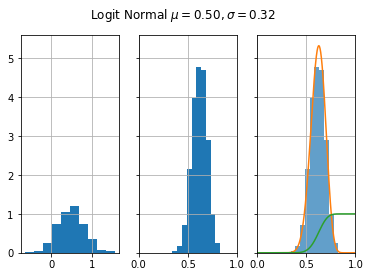

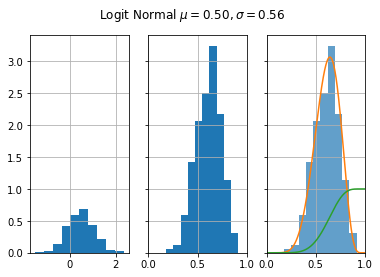

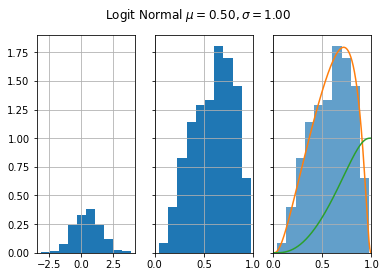

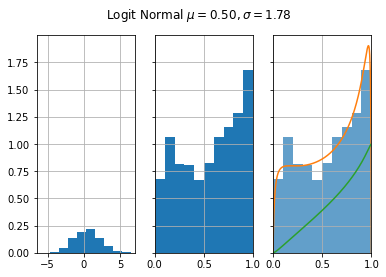

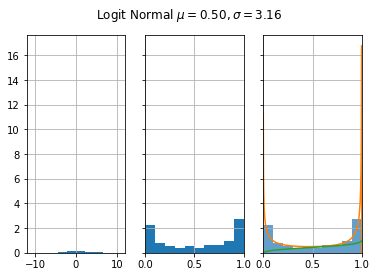

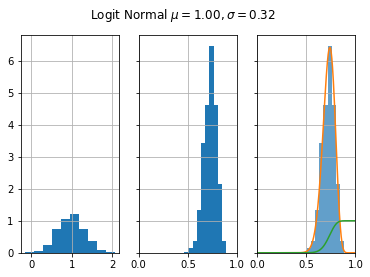

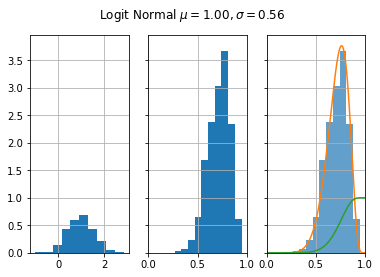

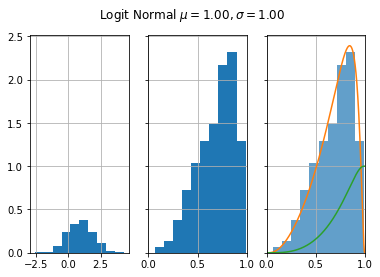

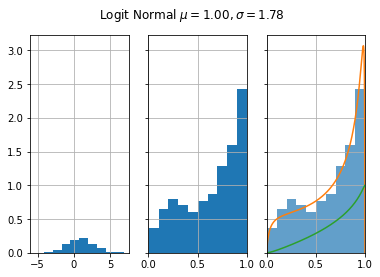

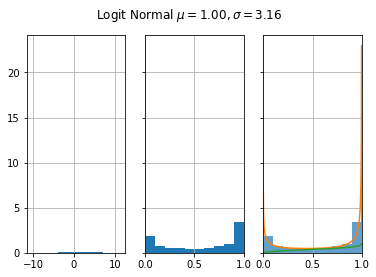

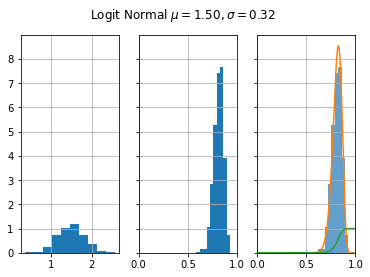

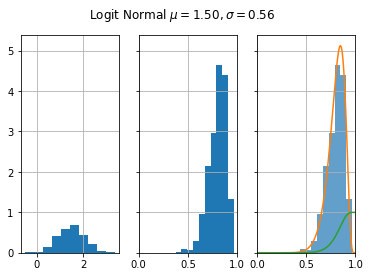

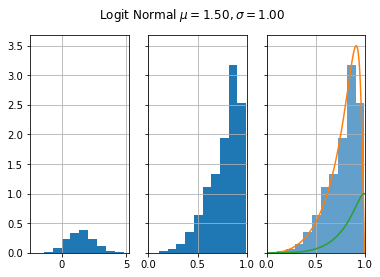

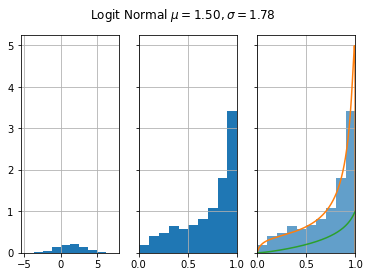

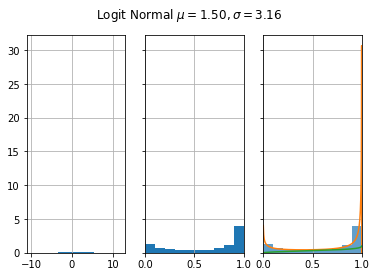

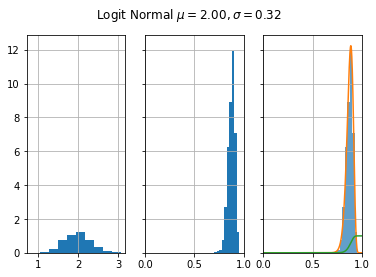

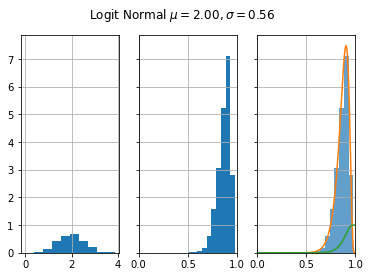

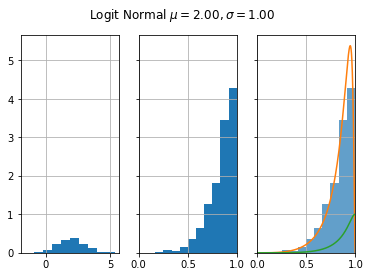

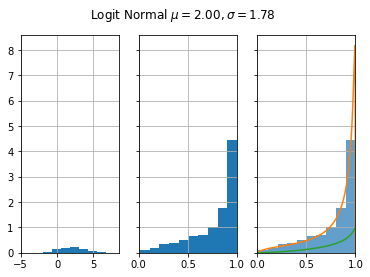

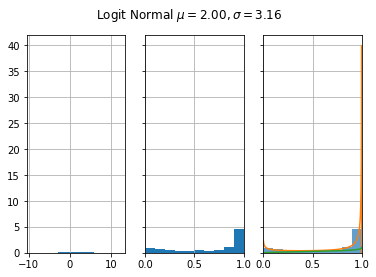

In [4]:
x = np.linspace(0.0001, 1.0001, 1000)
for fixture in fixtures:
    
    # Reference:
    normal = stats.norm(**fixture["parameters"])
    sample = normal.rvs(size=fixture["size"], random_state=fixture["seed"])
    reference = special.expit(sample)
    
    # Logit Normal Law:
    law = logitnorm(s=fixture["parameters"]["scale"], m=fixture["parameters"]["loc"])
    check = law.rvs(size=fixture["size"], random_state=fixture["seed"])
    
    # Fit:
    p = logitnorm.fit(reference)
    trial = logitnorm(*p)
    test = stats.kstest(check, trial.cdf)
    print(test)
    
    print(fixture, np.allclose(reference - check, 0.0))
    
    # Show:
    if True:
        fig, axe = plt.subplots(1, 3, sharey=True)
        axe[0].hist(sample, density=1)
        axe[1].hist(reference, density=1)
        axe[2].hist(check, alpha=0.7, density=1)
        axe[2].plot(x, law.pdf(x))
        axe[2].plot(x, law.cdf(x))
        fig.suptitle("Logit Normal $\mu={loc:.2f}, \sigma={scale:.2f}$".format(**fixture["parameters"]))
        for i in range(3):
            axe[i].grid()
            if i > 0:
                axe[i].set_xlim([0, 1])